# CARND P5 VEHICLE DETECTION BY Qitong

In [1]:
import cv2
import glob
from lesson_functions import *
from helper_functions import *
from sklearn.utils import shuffle

In [2]:
image_car_paths = glob.glob('training/cars/*')
image_notcar_paths = glob.glob('training/notcars/*')
cars = []
notcars = []

for image in image_car_paths:
    cars.append(image)
for image in image_notcar_paths:
    notcars.append(image)
shuffle(cars)
shuffle(notcars)
print('load data finished')
print(len(cars))
print(len(notcars))

load data finished
6941
8968


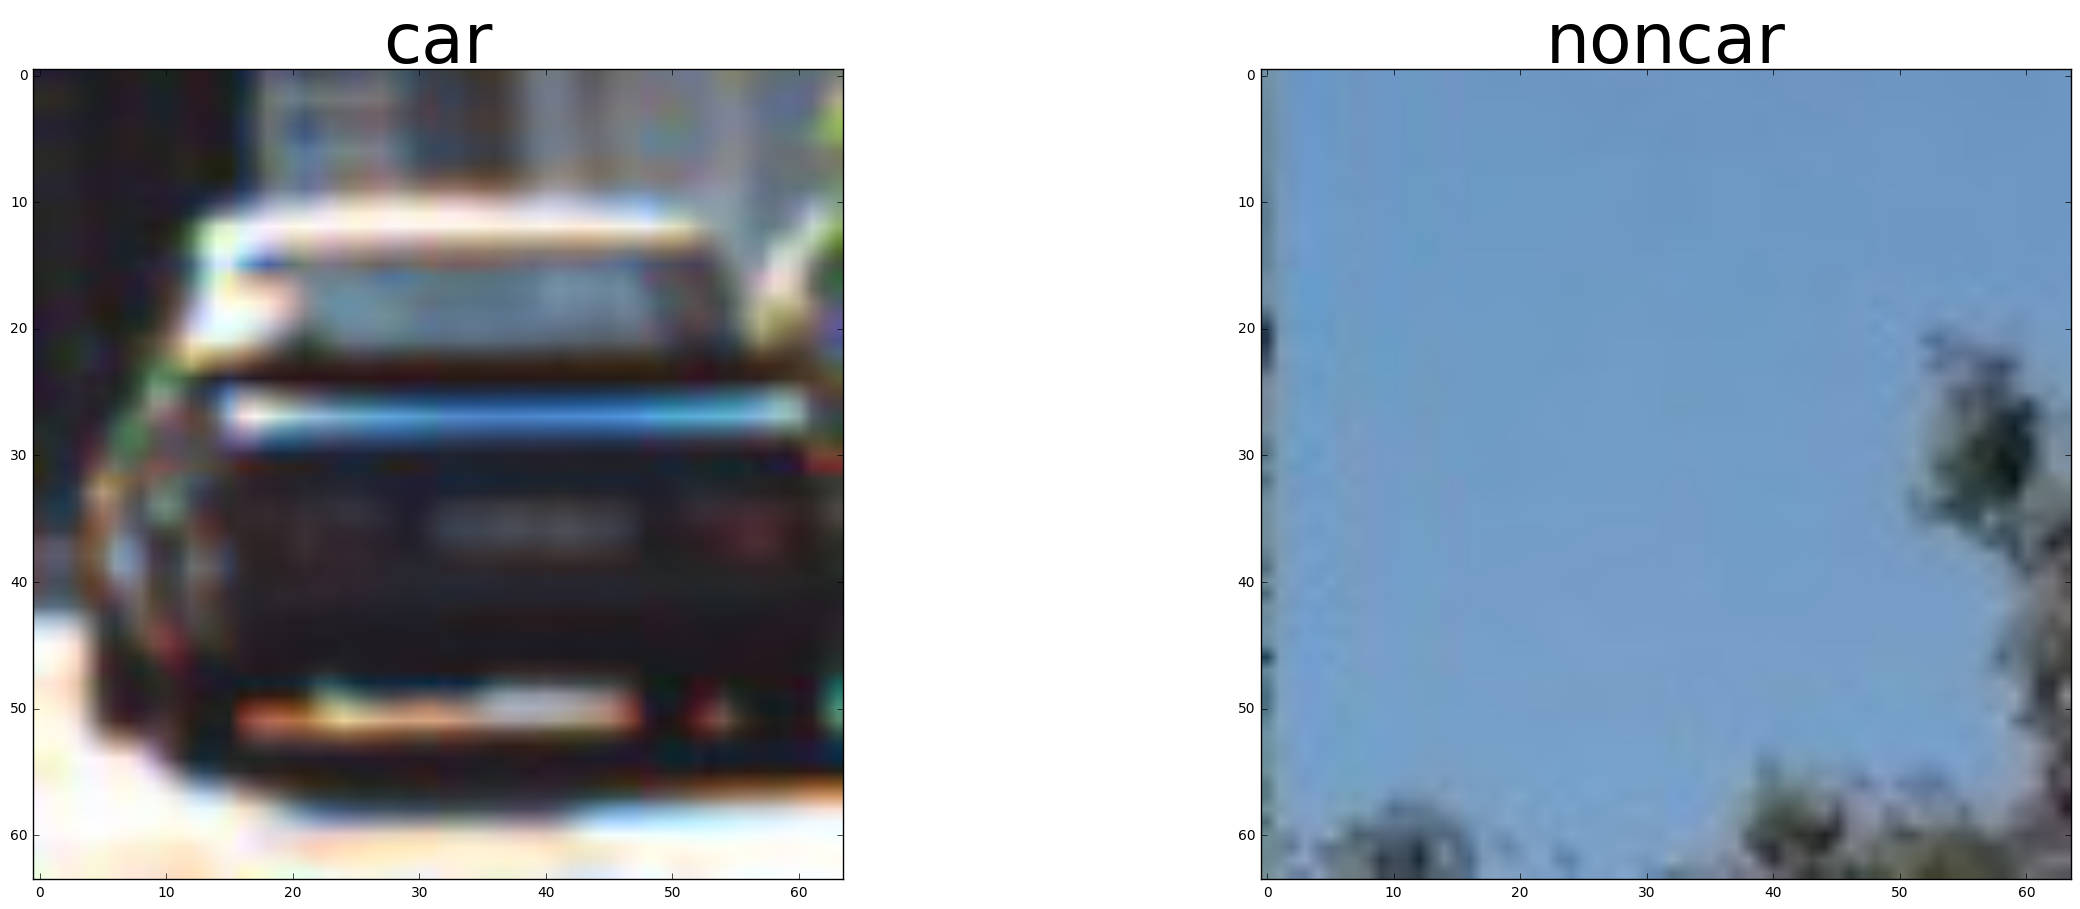

In [3]:
image_car_sample = mpimg.imread(cars[0])
image_noncar_sample = mpimg.imread(notcars[0])
show_two_images(image_car_sample, image_noncar_sample,'car','noncar')

In [4]:
def show_hog_feature(rgb_image, color_space='RGB'):
    hog_images = []
    feature_image = convert_color_space(rgb_image, color_space)
    for channel in range(3):
        _, hog_image = get_hog_features(feature_image[:,:,channel], orient=9, pix_per_cell=8, cell_per_block=2,vis=True)
        hog_images.append(hog_image)
    return hog_images

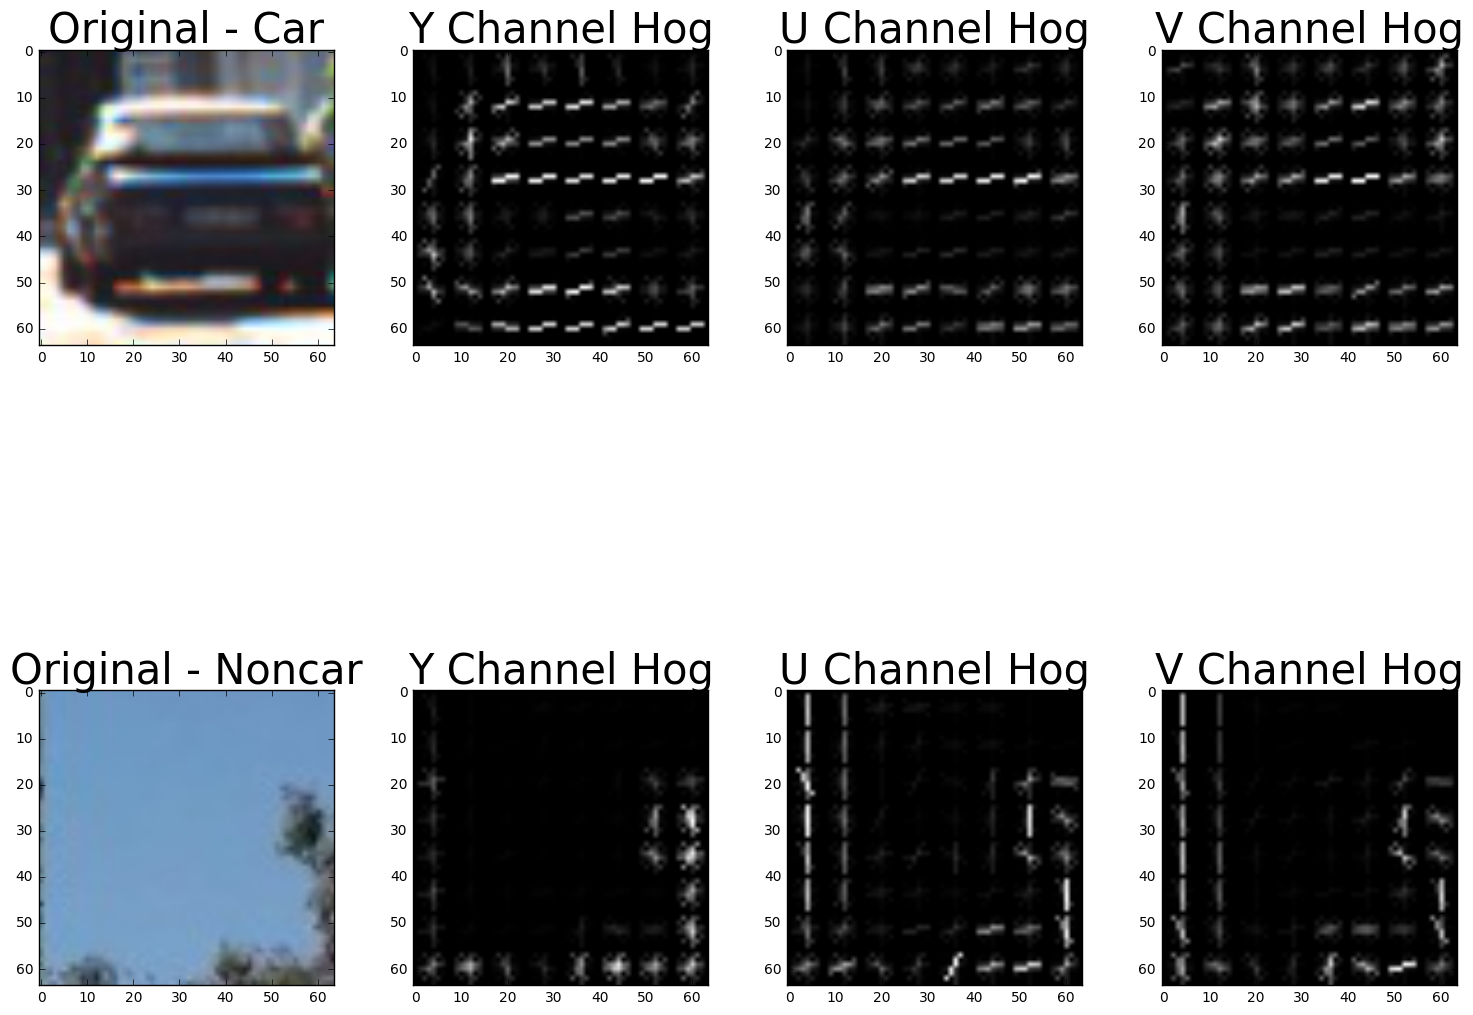

In [5]:
hogs_car = show_hog_feature(image_car_sample, color_space='YUV')
image_list = [image_car_sample]
image_list.extend(hogs_car)
hogs_noncar = show_hog_feature(image_noncar_sample, color_space='YUV')
image_list.append(image_noncar_sample)
image_list.extend(hogs_noncar)
show_images(image_list, nb_column=4, list_of_title_names =['Original - Car','Y Channel Hog', 'U Channel Hog', 'V Channel Hog','Original - Noncar','Y Channel Hog', 'U Channel Hog', 'V Channel Hog'])

In [6]:
COLOR_SPACE = 'YUV'
SPATIAL_SIZE = (32, 32)
HIST_BINS = 32
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHANNEL = 'ALL'

In [7]:
def extract_feature_from_images(images):
    features = extract_features(images, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL, spatial_feat=True, hist_feat=True, hog_feat=True)
    return features

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def prepare_training_set():
    car_features = extract_feature_from_images(cars)
    notcar_features = extract_feature_from_images(notcars)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    return X_train, X_test, y_train, y_test, X_scaler

In [9]:
X_train, X_test, y_train, y_test, X_scaler = prepare_training_set()

In [27]:
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score

In [28]:
clf = LinearSVC() # SVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [29]:
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print(acc)

0.992457573853


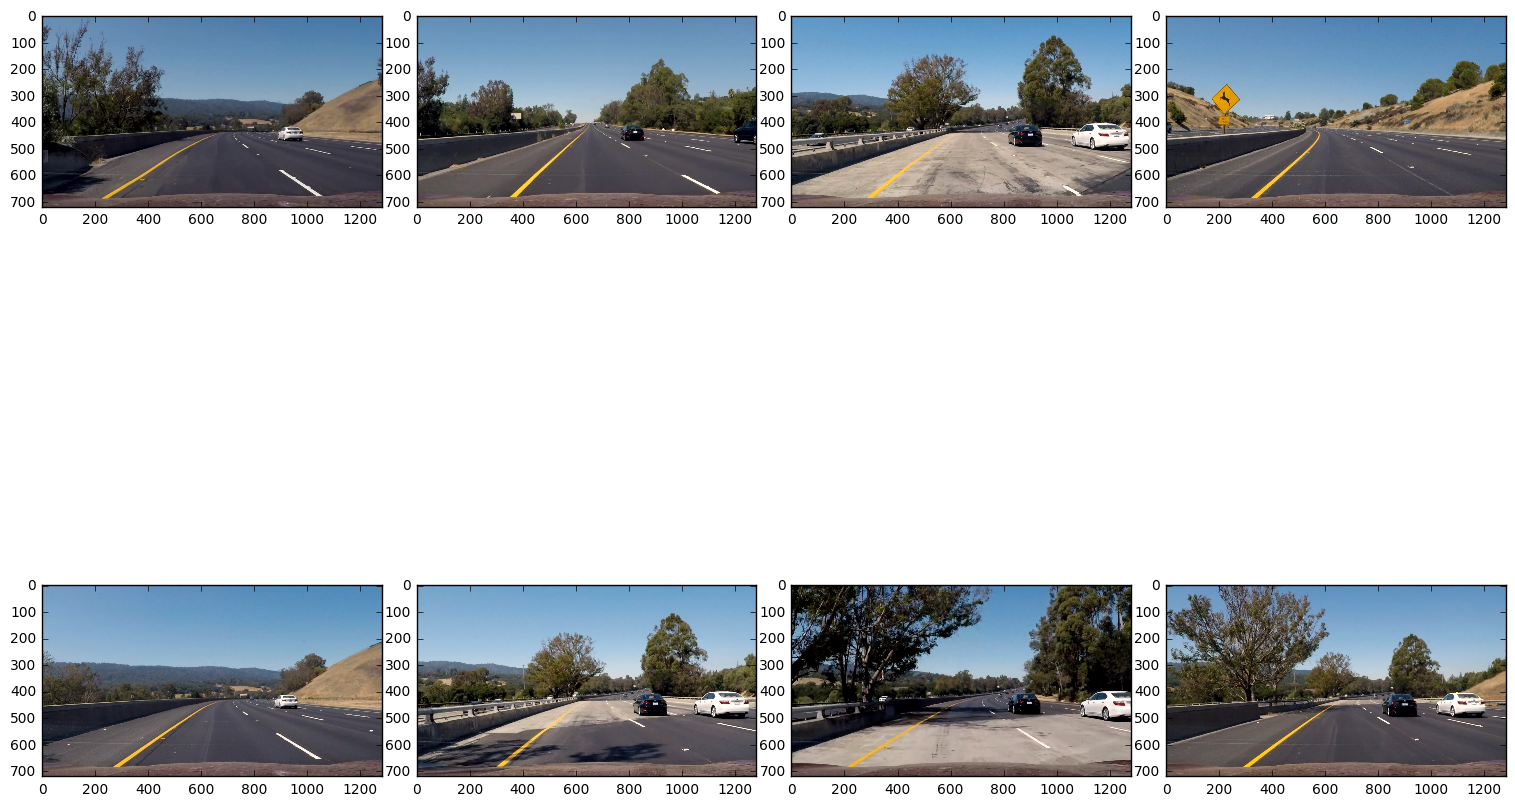

In [30]:
test_images_path = glob.glob('test_images/*.jpg')
test_images = [mpimg.imread(x) for x in test_images_path]
show_images(test_images, nb_column=4)

In [31]:
def slide_window_with_variant_size(image):
    windows1 = slide_window(image, x_start_stop=[420,None], y_start_stop=[300,550], xy_window=(64,64), xy_overlap=(0.5,0.5))
    windows2 = slide_window(image, x_start_stop=[420,None], y_start_stop=[350,650], xy_window=(100,100), xy_overlap=(0.5,0.5))
    windows3 = slide_window(image, x_start_stop=[420,None], y_start_stop=[400,700], xy_window=(120,120), xy_overlap=(0.5,0.5))
    windows1.extend(windows2)
    windows1.extend(windows3)
    return windows1 
#     im_to_draw = np.copy(image)
#     window_img = draw_boxes(im_to_draw, windows1, color=(0, 0, 255), thick=3)
#     window_img = draw_boxes(window_img, windows2, color=(0, 255, 0), thick=4)
#     window_img = draw_boxes(window_img, windows3, color=(255, 0, 0), thick=5)
#     plt.imshow(window_img)
#     plt.show()

In [32]:
def slide_window_on_image(image):
    window_list = slide_window_with_variant_size(image)
    hot_window = search_windows(image, window_list, clf, X_scaler, color_space=COLOR_SPACE, spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                                orient=ORIENT, pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, 
                                hog_channel=HOG_CHANNEL, spatial_feat=True, hist_feat=True, hog_feat=True)
    return hot_window

In [33]:
hot_window = slide_window_on_image(test_images[2])

In [91]:
def find_car_in_field(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    x_start = 640
    draw_img = np.copy(img)
    #img = img.astype(np.float32)
    
    img_tosearch = draw_img[ystart:ystop,x_start:,:]
    #img_tosearch = img_tosearch[:,400:,:]
    ctrans_tosearch = convert_color_space(img_tosearch, 'YUV')
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    detection = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                detection.append(((xbox_left+x_start, ytop_draw+ystart),(xbox_left+x_start+win_draw,ytop_draw+win_draw+ystart)))
    return detection #draw_img

In [92]:
def find_car_in_one_shot(image):
    result = []
    scale_number = [1, 1.5, 2]
    y_pos = [(300,700), (300,700), (300,700)]
    for i in range(len(scale_number)):
        detection = find_car_in_field(image,ystart=y_pos[i][0], ystop=y_pos[i][1], scale=scale_number[i], svc=clf, X_scaler=X_scaler, orient=ORIENT, 
              pix_per_cell=PIX_PER_CELL, cell_per_block=CELL_PER_BLOCK, spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS)
        result.extend(detection)
    return result    

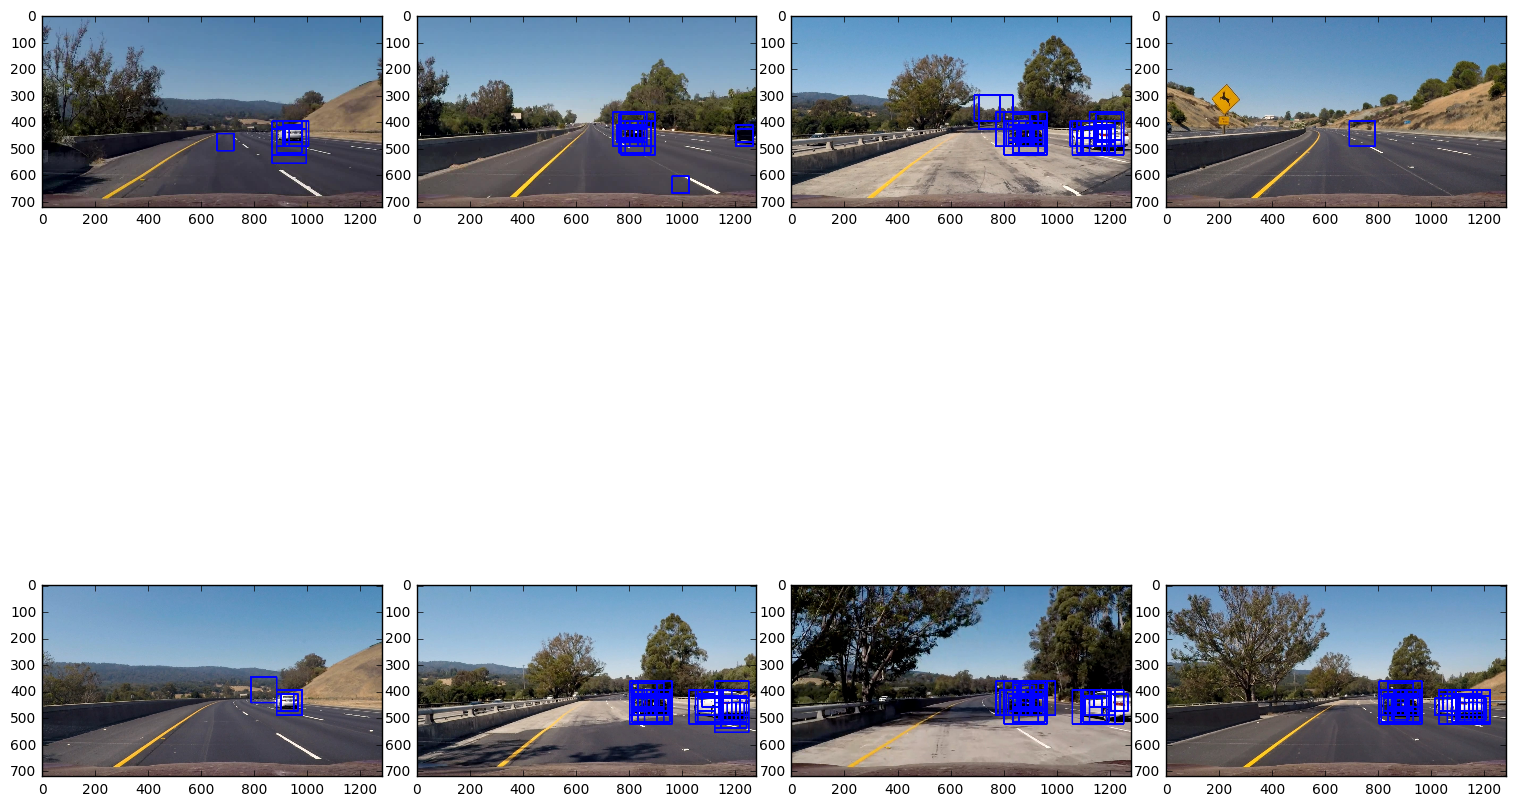

In [93]:
image_of_boxes = []
detection_boxes = []
for image in test_images:
    detection_box = find_car_in_one_shot(image)
    window_img = draw_boxes(image, detection_box)
    image_of_boxes.append(window_img)
    detection_boxes.append(detection_box)
show_images(image_of_boxes, 4)

In [94]:
def draw_hot_window_on_image(image):
    image_to_draw = np.copy(image)
    hot_window = slide_window_on_image(image)
    window_img = draw_boxes(image_to_draw, hot_window)
    plt.imshow(window_img)
    plt.show()
    return window_img

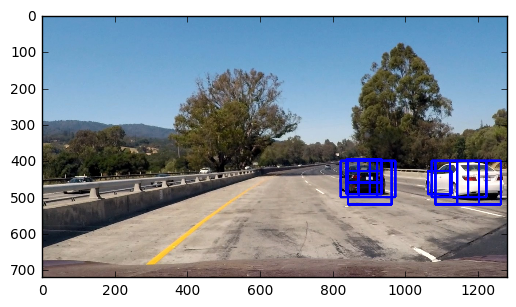

In [95]:
window_img = draw_hot_window_on_image(test_images[2])

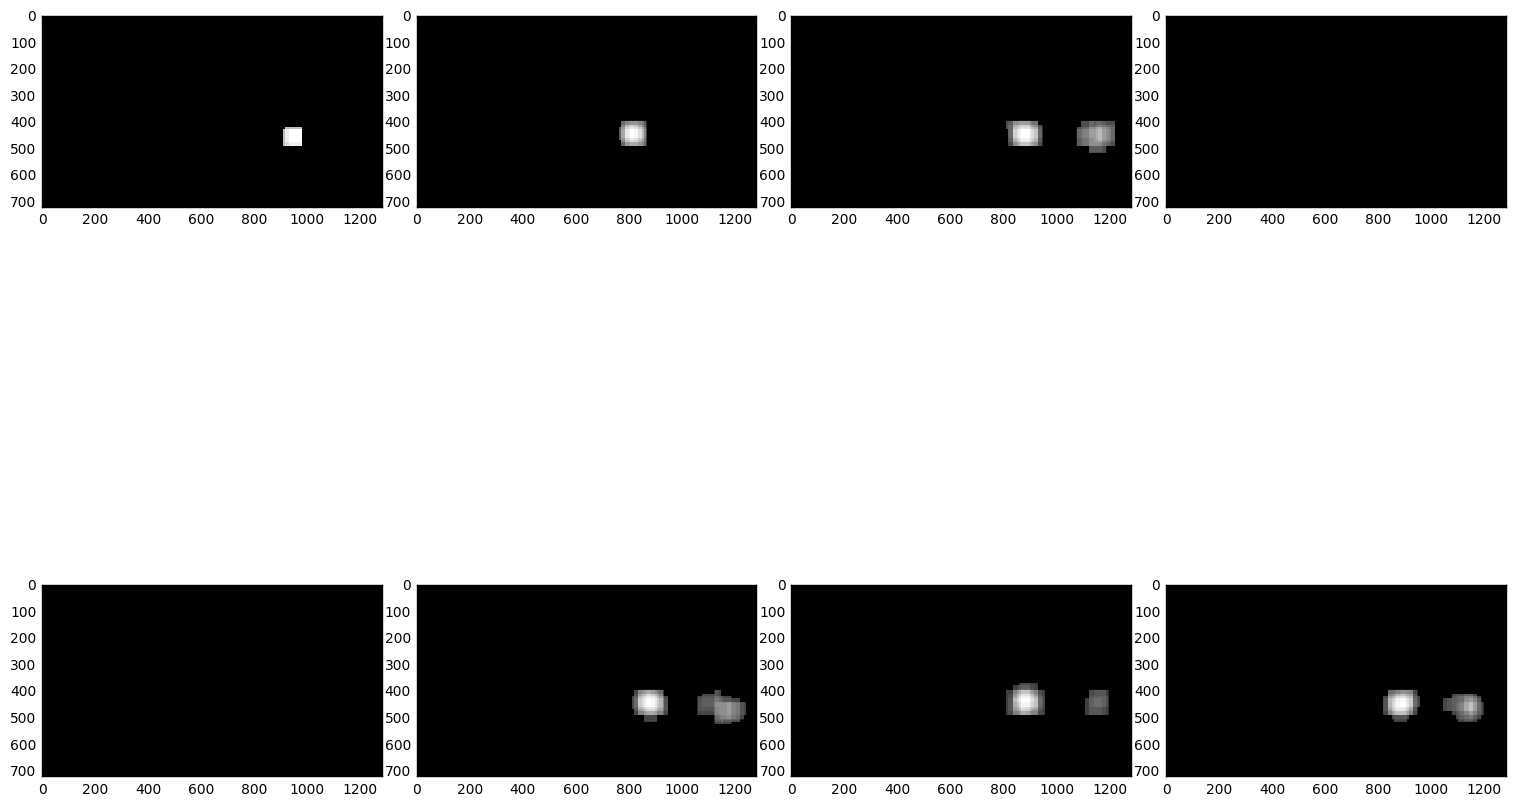

In [100]:
heatmap_of_test_images = []
for i in range(len(image_of_boxes)):
    img = heatmap_with_threshold(image_of_boxes[i], detection_boxes[i], 4)
    heatmap_of_test_images.append(img)
show_images(heatmap_of_test_images, 4)

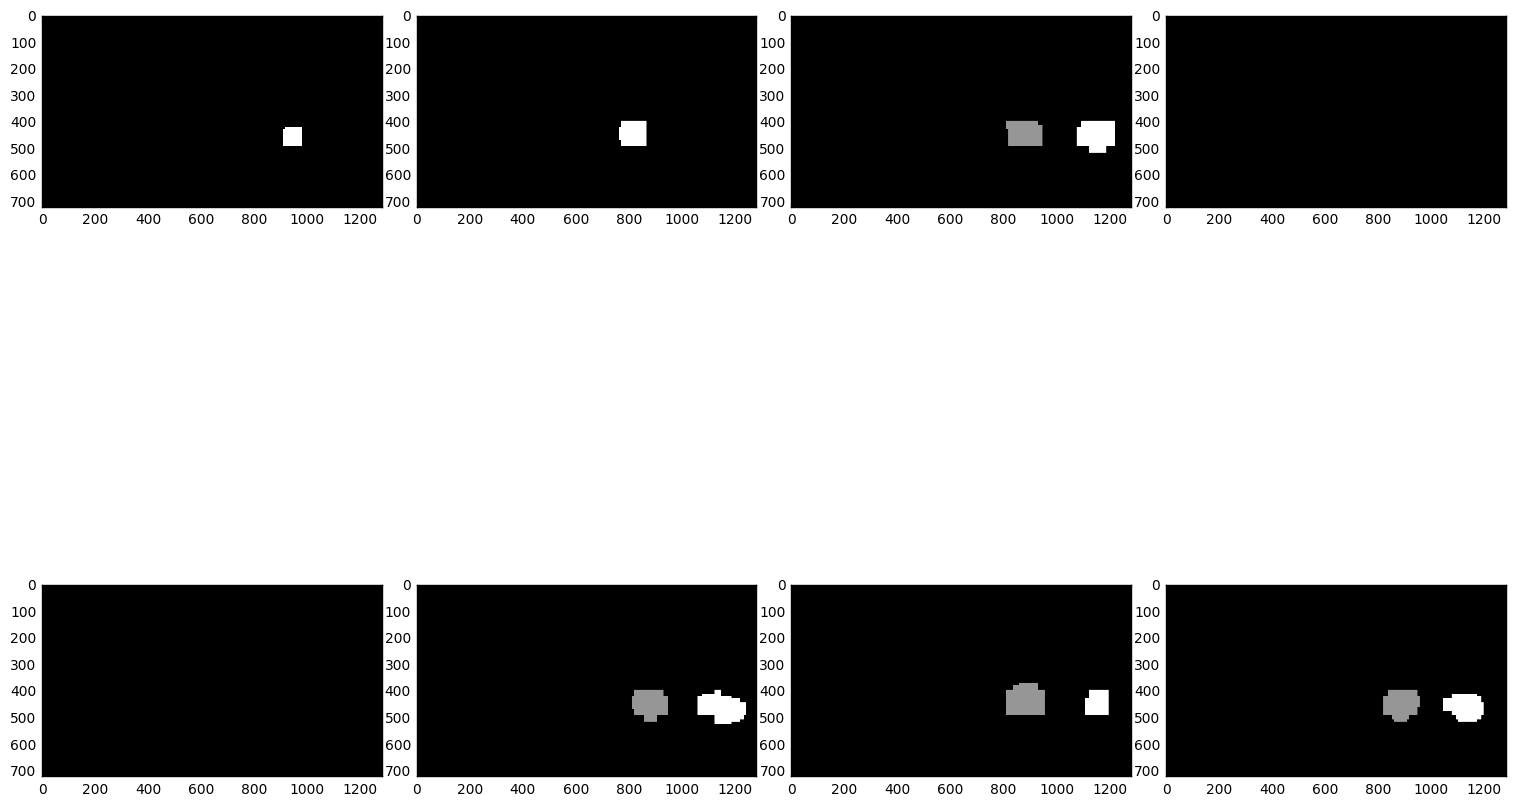

In [101]:
label_images = []
for heatmap in heatmap_of_test_images:
    label_of_img = label(heatmap)
    label_images.append(label_of_img[0])
show_images(label_images, 4)
# draw_img = draw_labeled_bboxes(np.copy(test_image_box), labels)
# plt.imshow(draw_img, cmap='Greys_r')
# plt.show()

#### Time Sequence False Positive Rejection

In [113]:
import queue
HEATMAP_Q_SIZE = 10
heatmap_q = queue.Queue(maxsize=HEATMAP_Q_SIZE)
frame_thresh = 3

In [114]:
def sum_heat_maps(heat_maps):
    result = np.zeros_like(heat_maps[0])
    for heat_map in heat_maps:
        result = np.add(result, heat_map)
    return result

def binarize_heat_map(heatmap):
    binary_heatmap = np.zeros_like(heatmap)
    binary_heatmap[heatmap>1] = 1
    return binary_heatmap

def time_sequence_fp_rejection(current_heat_map):
    corrected_map = np.zeros_like(current_heat_map)
    binary_heatmap = binarize_heat_map(current_heat_map)
    if heatmap_q.full():
        heat_maps = np.array(list(heatmap_q.queue))
        sum_of_heatmaps = sum_heat_maps(heat_maps)
        #corrected_map = np.zeros_like(current_heat_map)
        corrected_map[((sum_of_heatmaps>frame_thresh) & (current_heat_map>1))] = 1
        heatmap_q.get()
    heatmap_q.put(binary_heatmap)
    return corrected_map

In [115]:
def pipeline(image, time_rejection=False):
    hot_windows = find_car_in_one_shot(image) #slide_window_on_image(image)
    img = heatmap_with_threshold(image, hot_windows, 3)
    if time_rejection:
        img = time_sequence_fp_rejection(img)
    labels = label(img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

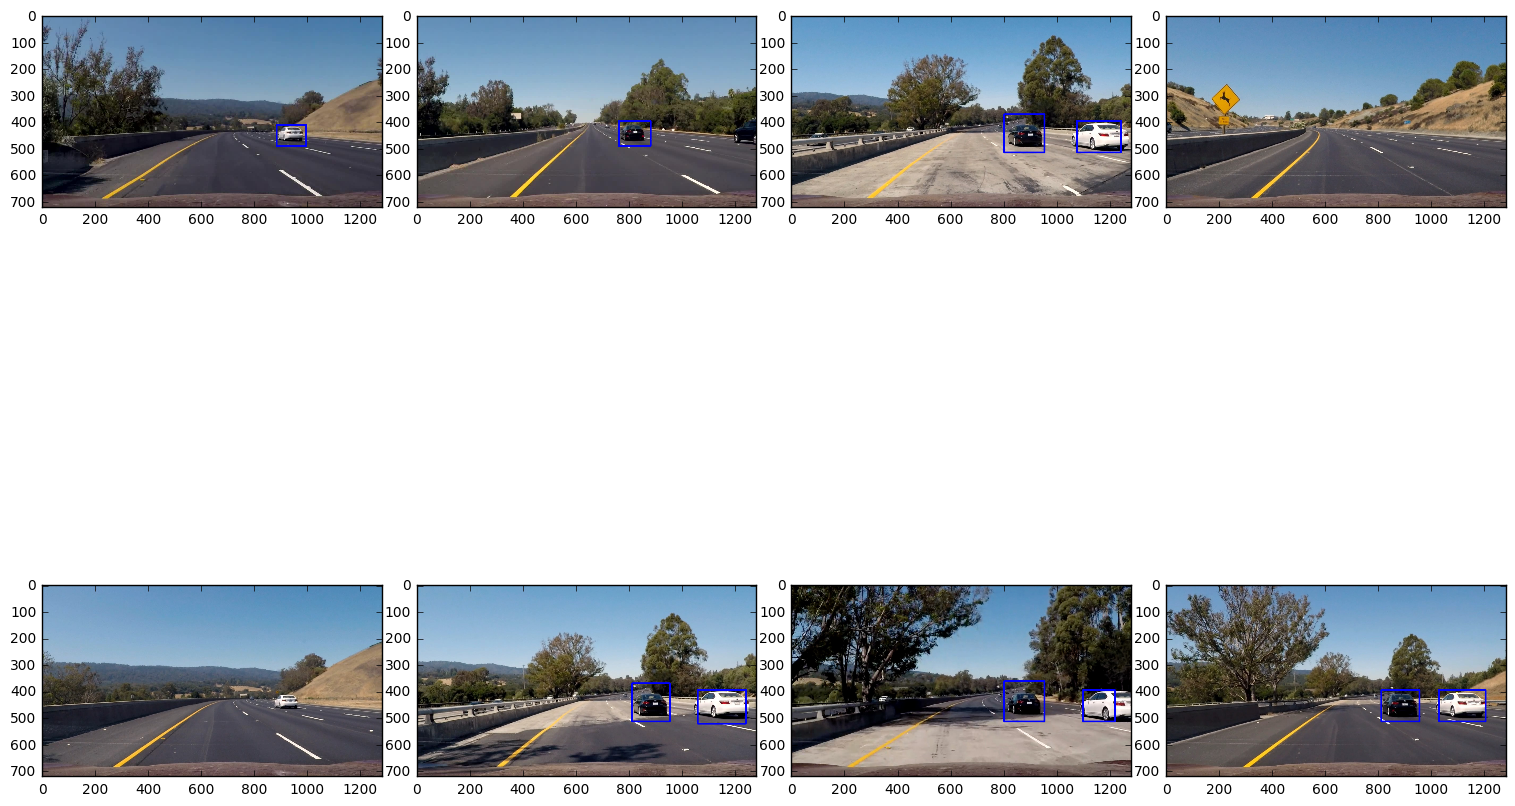

In [106]:
final_imgs = [pipeline(x) for x in test_images]
show_images(final_imgs, 4)

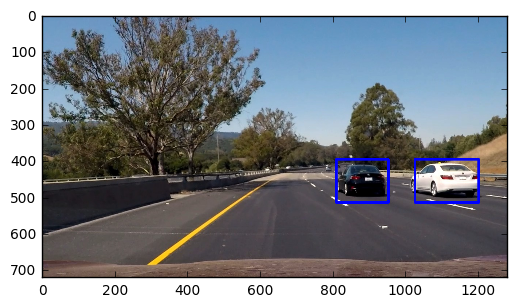

In [107]:
test_img_pipeline = pipeline(test_images[-1])
plt.imshow(test_img_pipeline)
plt.show()

In [116]:
def process_video(image):
    return pipeline(image,time_rejection=True)
    

In [109]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [117]:
proj_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4



100%|█████████▉| 1260/1261 [26:38<00:01,  1.27s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

CPU times: user 24min 51s, sys: 1min 54s, total: 26min 46s
Wall time: 26min 38s


In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_output))